In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([[1],[2],[3],[4],[5],[6],[7],[8]])
y = np.array([1,2,1.5,3.5,4,5,4.5,6])

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    criterion="squared_error",
    max_depth=None,      # fully grown tree
    min_samples_leaf=1
)

tree.fit(X, y)


DecisionTreeRegressor()

In [ ]:
X_test = np.linspace(1, 8, 100).reshape(-1,1)
y_pred = tree.predict(X_test)


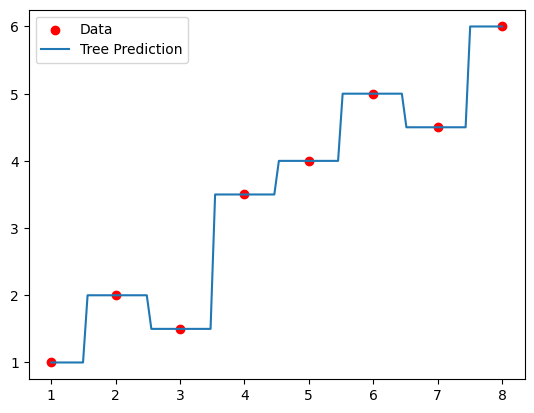

In [ ]:
plt.scatter(X, y, color='red', label='Data')
plt.plot(X_test, y_pred, label='Tree Prediction')
plt.legend()
plt.show()


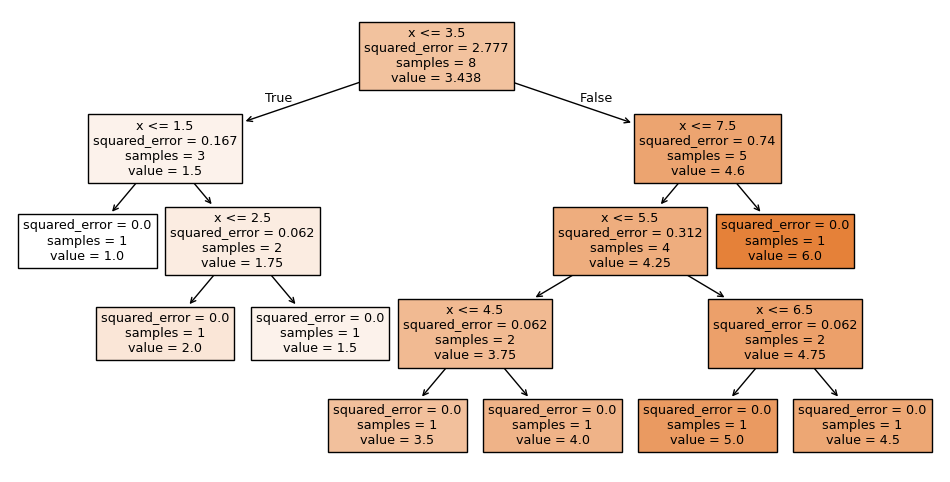

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,6))
plot_tree(tree, feature_names=["x"], filled=True)
plt.show()


### Each internal node shows:

Split condition: x <= s

MSE at node

Number of samples

Mean value

📌 This is your RSS-based greedy splitting in action.

## Overfitting Demonstration (Very Important)

Let’s check training vs test error.

In [ ]:
from sklearn.metrics import mean_squared_error

print("Train MSE:", mean_squared_error(y, tree.predict(X)))


Train MSE: 0.0


Reduced Error Pruning (Practically)

Sklearn does NOT implement REP directly, but conceptually:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

print("Validation MSE:", mean_squared_error(y_val, tree.predict(X_val)))


Validation MSE: 0.5


## Cost–Complexity Pruning (CART Way)
Step 1: Get α values

In [ ]:
path = tree.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
print(ccp_alphas)


[0.         0.015625   0.015625   0.015625   0.046875   0.125
 0.30625    2.25234375]


In [ ]:
trees = []

for alpha in ccp_alphas:
    t = DecisionTreeRegressor(ccp_alpha=alpha)
    t.fit(X, y)
    trees.append(t)


## Choose best α (Cross-validation)

In [ ]:
errors = [mean_squared_error(y, t.predict(X)) for t in trees]

best_alpha = ccp_alphas[np.argmin(errors)]
print("Best alpha:", best_alpha)


Best alpha: 0.0


# Decision Tree from Scratch

### STAGE 0: We are going to implement the Greedy approach that is to minimise the RSS for each feature and finding the best split value

We want to implement:
  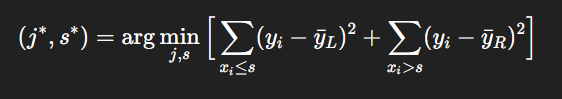

### STAGE 1 — Helper Mathematics Functions
1️⃣ Mean (leaf prediction)

In [17]:
def mean(y):
  return sum(y)/len(y)

### 2️⃣ Residual Sum of Squares (RSS)
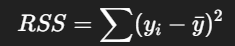

In [29]:
def rss(y):
  y_mean =mean(y)
  return sum((y_i - y_mean) ** 2 for y_i in y)


## STAGE 2 — Best Split for One Node (CORE LOGIC)

This function finds:

### Best feature j

### Best split value s

### Minimum RSS

In [31]:
def best_split(X, y):
  n_samples, n_features = len(X), len(X[0])


  best_j = None
  best_s = None
  best_error = float("inf")


  for j in range(n_features):


    sorted_data = sorted(zip(X,y), key = lambda x: x[0][j])
    sorted_X, sorted_y = zip(*sorted_data)

    for i in range(1, n_samples):
      s = (sorted_X[i-1][j] + sorted_X[i][j]) / 2

      y_left = sorted_y[:i]
      y_right = sorted_y[i:]

      error = rss(y_left) + rss(y_right)  ##Called here the rss function for calculating the error
      if error < best_error:
        best_error = error
        best_j = j
        best_s = s

  return best_j, best_s,



This is the greedy approximation
Exactly what sir writes on board.

## STAGE 3 — Tree Node Definition

Each node stores:

feature

split value

left child

right child

prediction (for leaf)

In [32]:
class Node:
    def __init__(self, feature=None, split=None, left=None, right=None, value=None):
        self.feature = feature
        self.split = split
        self.left = left
        self.right = right
        self.value = value




## STAGE 4 — Recursive Tree Construction

Stopping conditions:

max_depth

min_samples

No variance

In [33]:
def build_tree(X, y, depth=0, max_depth=3, min_samples=2):

    # stopping conditions
    if len(y) < min_samples or depth == max_depth or rss(y) == 0:
        return Node(value=mean(y))

    feature, split = best_split(X, y)

    if feature is None:
        return Node(value=mean(y))

    X_left, y_left = [], []
    X_right, y_right = [], []

    for xi, yi in zip(X, y):
        if xi[feature] <= split:
            X_left.append(xi)
            y_left.append(yi)
        else:
            X_right.append(xi)
            y_right.append(yi)

    left_child = build_tree(X_left, y_left, depth+1, max_depth, min_samples)
    right_child = build_tree(X_right, y_right, depth+1, max_depth, min_samples)

    return Node(feature, split, left_child, right_child)


### 📌 This is top-down greedy CART growth.

## STAGE 5 — Prediction Function

In [34]:
def predict_one(node, x):
    if node.value is not None:
        return node.value

    if x[node.feature] <= node.split:
        return predict_one(node.left, x)
    else:
        return predict_one(node.right, x)


def predict(tree, X):
    return [predict_one(tree, x) for x in X]


## STAGE 6 — Test on Real Data

In [35]:
X = [[1],[2],[3],[4],[5],[6],[7],[8]]
y = [1,2,1.5,3.5,4,5,4.5,6]

tree = build_tree(X, y, max_depth=3)

preds = predict(tree, X)
print(preds)


[1.0, 2.0, 1.5, 3.75, 3.75, 4.75, 4.75, 6.0]
